In [48]:
%matplotlib inline

import sys

sys.path.append('..')

import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import product
from datetime import datetime
import os
import matplotlib.pyplot as plt
from open_ocean.utils import convert_climatology_to_ocean_areas
import open_ocean.gridder as gridder
import open_ocean.interpolation as io

In [49]:
def convert_dates(months, days):
    return [datetime(2020, months[i], days[i]) for i in range(len(months))]

In [50]:
data_dir = Path(os.getenv("OODIR"))
coder = xr.coders.CFDatetimeCoder(time_unit="s")

Interpolation
=============

As a first pass on the interpolation, I'm going to use a basic Gaussian Process. I will treat the grid cell centres as the locations of the observations and the grid cell averages as the observation values. In principle, we could go straight from the individual observations to a gridded representation, but doing it this way means I can make use of the observational error covariances while keeping the computational costs reasonable. I'm running this on my desktop machine which isn't especially powerful. It's no slouch, but when I've run this kind of thing before I've had access to a large amount of processing. So. I'm trying to keep it simple.

Kriging and Gaussian Processes on a globe can be a bit of a pain because most of the standard routines assume your domain is not curved. Our observations are points on the surface of a sphere specified by latitudes and longitudes. We could treat these as x and y in a 2D space, but this can cause numerical problems when we start to build covariance matrices and calculate distances between them. One solution, or so I'm told, is to convert latitudes and longitudes to their three cartesian coordinates and do the GP in 3D. This is easy to do, so that's what I did.

To further simplify my task, I used some default values for the Gaussian Process, which I suspect will work quite well (they worked fine for HadCRUT5). I calculate the Matern covariance between points using a length scale of 1300km, a variance of 0.6K, and with a shape factor of 1.5, which is intermediate between a simple exponential and a gaussian. It's a sharp gaussian, or a blunt exponential. The results of this kind of interpolation are a little blobby for my liking, so I've thrown something random into the mix: I stretch the z-coordinate by a factor of 3 which has the effect of making the resolved features more zonal i.e. they stretch further east to west than they do north to south.

In [51]:
climatology = xr.open_dataset(data_dir / "SST_CCI_climatology" / "SST_1x1_daily.nc")
areas = convert_climatology_to_ocean_areas(climatology)
sampling_unc = xr.open_dataset(data_dir / "IQUAM" / "OutputData" / "sampling_uncertainty.nc")


In [52]:
year = 1983
month = 6

file = data_dir / 'IQUAM' / f'{year}{month:02d}-STAR-L2i_GHRSST-SST-iQuam-V2.10-v01.0-fv01.0.nc'

iquam = xr.open_dataset(file, decode_timedelta=coder)
quality = iquam.quality_level.values
selection = (quality >= 4)

id = iquam.platform_id.values[selection]
type = iquam.platform_type.values[selection]
lats = iquam.lat.values[selection]
lons = iquam.lon.values[selection]
values = iquam.sst.values[selection]

# Convert dates
dates = convert_dates(
    iquam.month.values[selection].astype(int),
    iquam.day.values[selection].astype(int)
)

# Grid up the data
grid = gridder.Grid(2020, 10, id, lats, lons, dates, values, type, climatology)
grid.add_sampling_uncertainties(sampling_unc)
grid.do_1x1_gridding()
grid.do_one_step_5x5_gridding()
grid.calculate_covariance()

That builds the basic grid from data for June 1983. At the moment, it looks like this, with an El Nino hanging around in the Pacific, but we can also see gaps, over the Southern Ocean, amongst other places.

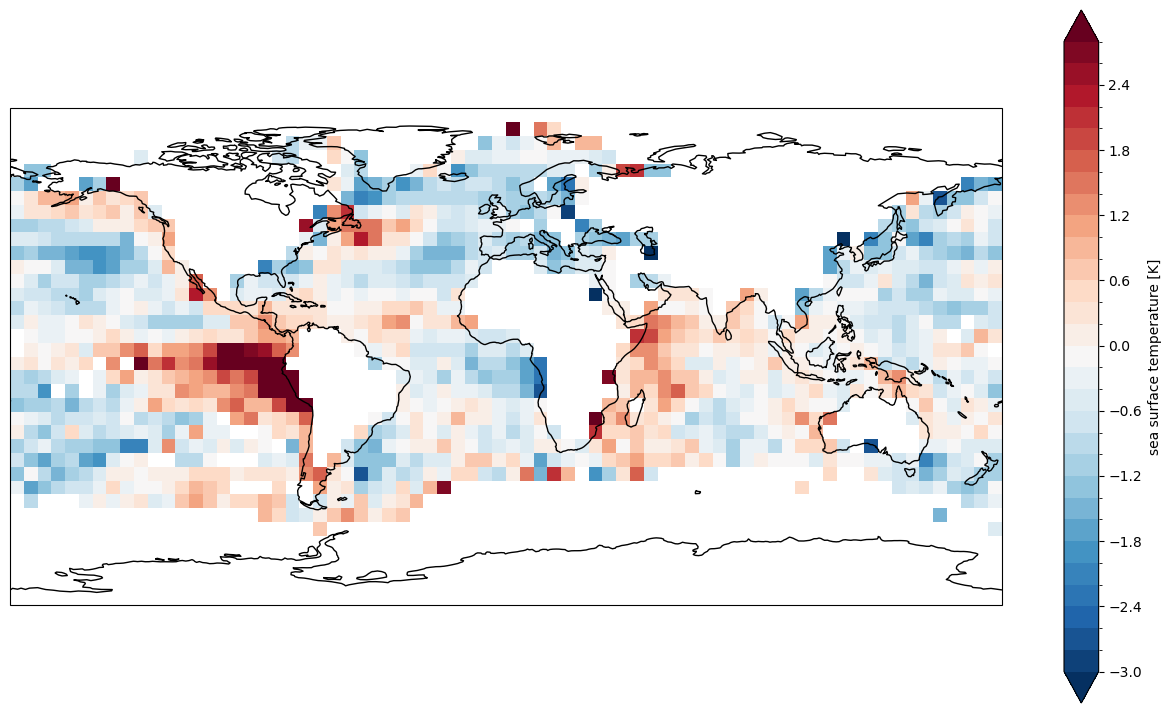

In [53]:
grid.plot_map_5x5()

In [54]:
# Set up the interpolation
kernel = io.Kernel(0.6, 1300.0,1.5)
interp = io.GPInterpolator(grid, kernel)
interp.make_covariance(constant=0.2)
interpolated_grid = interp.do_interpolation()
interpolated_grid.data5[np.isnan(sampling_unc.sst.values[0:1,:,:])] = np.nan

C:\Users\johnk\PycharmProjects\open-ocean\open_ocean\interpolation.py:37: RuntimeWarning: invalid value encountered in multiply
  (self.variance ** 2) *


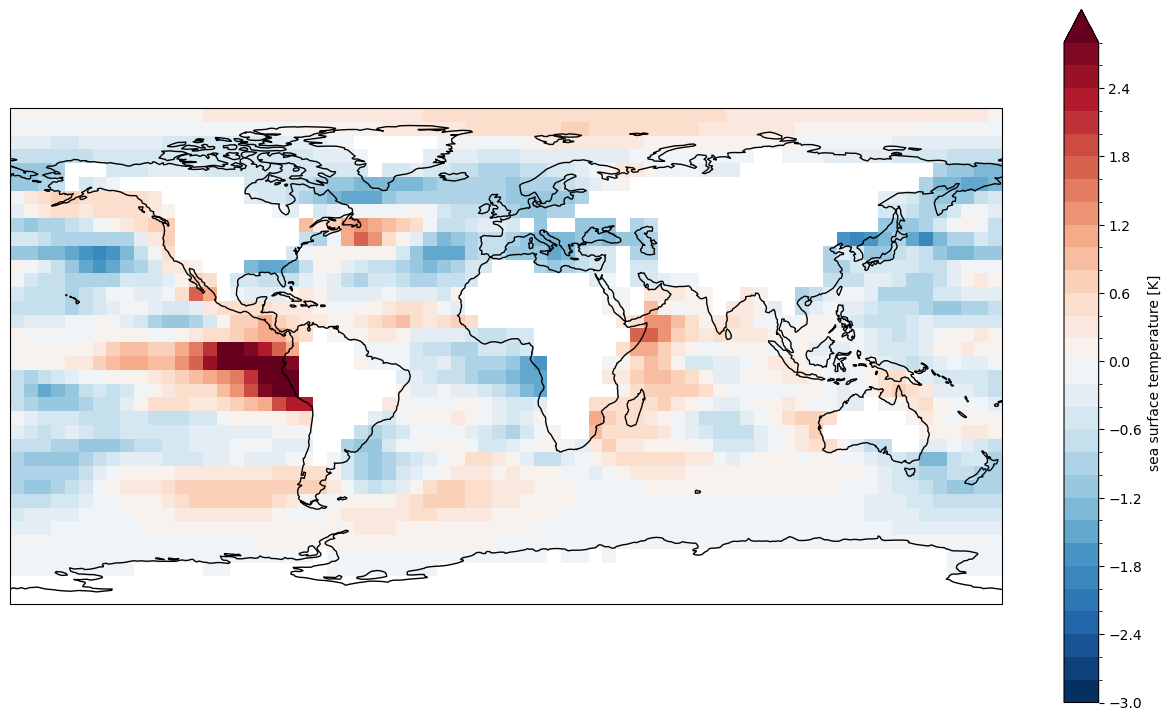

In [55]:
interpolated_grid.plot_map_5x5()